In [1]:
#@title Import Tensorflow ->  GPU
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
#@title Imports and Visualization parameters
# import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import math
from typing import Any, Optional

from keras.models import Sequential
from keras.regularizers import L1L2
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
tf.random.set_seed(42)


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('seaborn-colorblind')
sns.set_theme()
%matplotlib inline

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
          'figure.titlesize': 'x-large',
          'figure.dpi': 150,
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'savefig.bbox': 'tight'}

plt.rcParams.update(params)
# plt.rcParams.keys() ### Use to check the available parameters
#tf.debugging.set_log_device_placement(True) ### Use to debug use of GPU

# Select region

In [ ]:
region ='DK2'

# Data load

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%run 'drive/My Drive/MONTA/ts_modelling.py'

In [ ]:

df = pd.read_csv("drive/My Drive/MONTA/Spot_Price_Nordics.csv")
df = df[[f'{region}', "datetime"]]
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index("datetime", inplace = True)


In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
train_size = 1968
test_size = 96
df = df.iloc[len(df)-(test_size+train_size):]
df.reset_index() # No inplace, jsut to see index ranges

,datetime,DK2
0,2021-12-17 00:00:00,19.95
1,2021-12-17 01:00:00,19.36
2,2021-12-17 02:00:00,19.06
3,2021-12-17 03:00:00,19.15
4,2021-12-17 04:00:00,18.79
...,...,...
2059,2022-03-12 19:00:00,210.25
2060,2022-03-12 20:00:00,198.64
2061,2022-03-12 21:00:00,170.43
2062,2022-03-12 22:00:00,153.95


In [ ]:
data = df[:train_size]
test = df[train_size:]
p_min = data.min()
p_max = data.max()
ndata = (data-p_min)/(p_max-p_min)
ntest = (test-p_min)/(p_max-p_min)

# Modelling

In [ ]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

In [ ]:
train_size = 1968
test_size = 96
folds = 20
n_steps_in = 168
n_steps_out = 96
n_features = X.shape[2]

def prior_trainable(kernel_size: int, bias_size: int, dtype: Any) -> tf.keras.Model:
    """Specify the prior over 'keras.layers.Dense' 'kernel' and 'bias'."""
    n = kernel_size + bias_size
    
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
    ])

def posterior_mean_field(kernel_size: int, bias_size: int, dtype: Any) -> tf.keras.Model:
    """Specify the posterior over 'keras.layers.Dense' 'kernel' and 'bias'."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-4 + tf.nn.softplus(c + t[..., n:])),  ### Softplus ("soft" ReLU to ensure the scale is in the positive range). t parameter is for broadcasting!
          reinterpreted_batch_ndims=1)),
  ])


def build_model():
    model = Sequential()
    model.add(LSTM(200,
                   input_shape=(n_steps_in, n_features),
                   return_sequences=True,
                   kernel_regularizer=L1L2(l1=0.001, l2=0.001)))
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(n_steps_out+1))  # Output mean and different std.dev every time. (Mean and std.dev)
    model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(
                                          loc=t[..., :1],
                                          scale=0.0015 + tf.math.softplus(0.05 * t[..., 1:]))))  # Fit the standard deviation to the second term
    model.compile(optimizer='adam', loss=negloglik, metrics=['mae', 'mse']) # Negative loglikelihood.
    return model

model = build_model()

In [ ]:
n_steps_in = 168
n_steps_out = 96
# General data normalization

indexes=[]
preds = []

in_seq = ndata[:train_size].values
x_input = ndata[train_size-n_steps_in:].values  # Last sequence of in_seq, to use for prediction
y_true = ntest # Values to be predicted
# convert to [rows, columns] structure
in_seq = in_seq.reshape((len(in_seq), 1))
#in_seq2 = in_seq2.reshape((len(in_seq2), 1))
#out_seq = out_seq.reshape((len(out_seq), 1))
dataset=np.hstack((in_seq, in_seq))
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
n_features= X.shape[2]   

model = build_model()
print(X.shape,"\n")
print(y.shape)
history=model.fit(X, y, epochs=100, verbose=1, validation_split=0.1)
    

x_input = x_input.reshape((1, n_steps_in, n_features))

print(x_input.shape)
yhat = model(x_input)
assert isinstance(yhat, tfd.Distribution)

# with open(f'modelsummary_Fold_{ii}.txt', 'w') as f:
#    model.summary(print_fn=lambda x: f.write(x + '\n'))

(1706, 168, 1) 

(1706, 96)
Epoch 1/100
48/48 [==============================] - 3s 26ms/step - loss: 0.7718 - mae: 0.5237 - mse: 0.4316 - val_loss: 0.5251 - val_mae: 0.5232 - val_mse: 0.4304
Epoch 2/100
48/48 [==============================] - 1s 15ms/step - loss: 0.4662 - mae: 0.4970 - mse: 0.3893 - val_loss: 0.4533 - val_mae: 0.4788 - val_mse: 0.3565
Epoch 3/100
48/48 [==============================] - 1s 15ms/step - loss: 0.5511 - mae: 0.4737 - mse: 0.3554 - val_loss: 0.4515 - val_mae: 0.4900 - val_mse: 0.3760
Epoch 4/100
48/48 [==============================] - 1s 15ms/step - loss: 0.3247 - mae: 0.4358 - mse: 0.3019 - val_loss: 0.1372 - val_mae: 0.3345 - val_mse: 0.1698
Epoch 5/100
48/48 [==============================] - 1s 15ms/step - loss: 3.6154 - mae: 0.6892 - mse: 0.7388 - val_loss: 0.5049 - val_mae: 0.5172 - val_mse: 0.4190
Epoch 6/100
48/48 [==============================] - 1s 15ms/step - loss: 0.5098 - mae: 0.5196 - mse: 0.4245 - val_loss: 0.5289 - val_mae: 0.5242 - val_

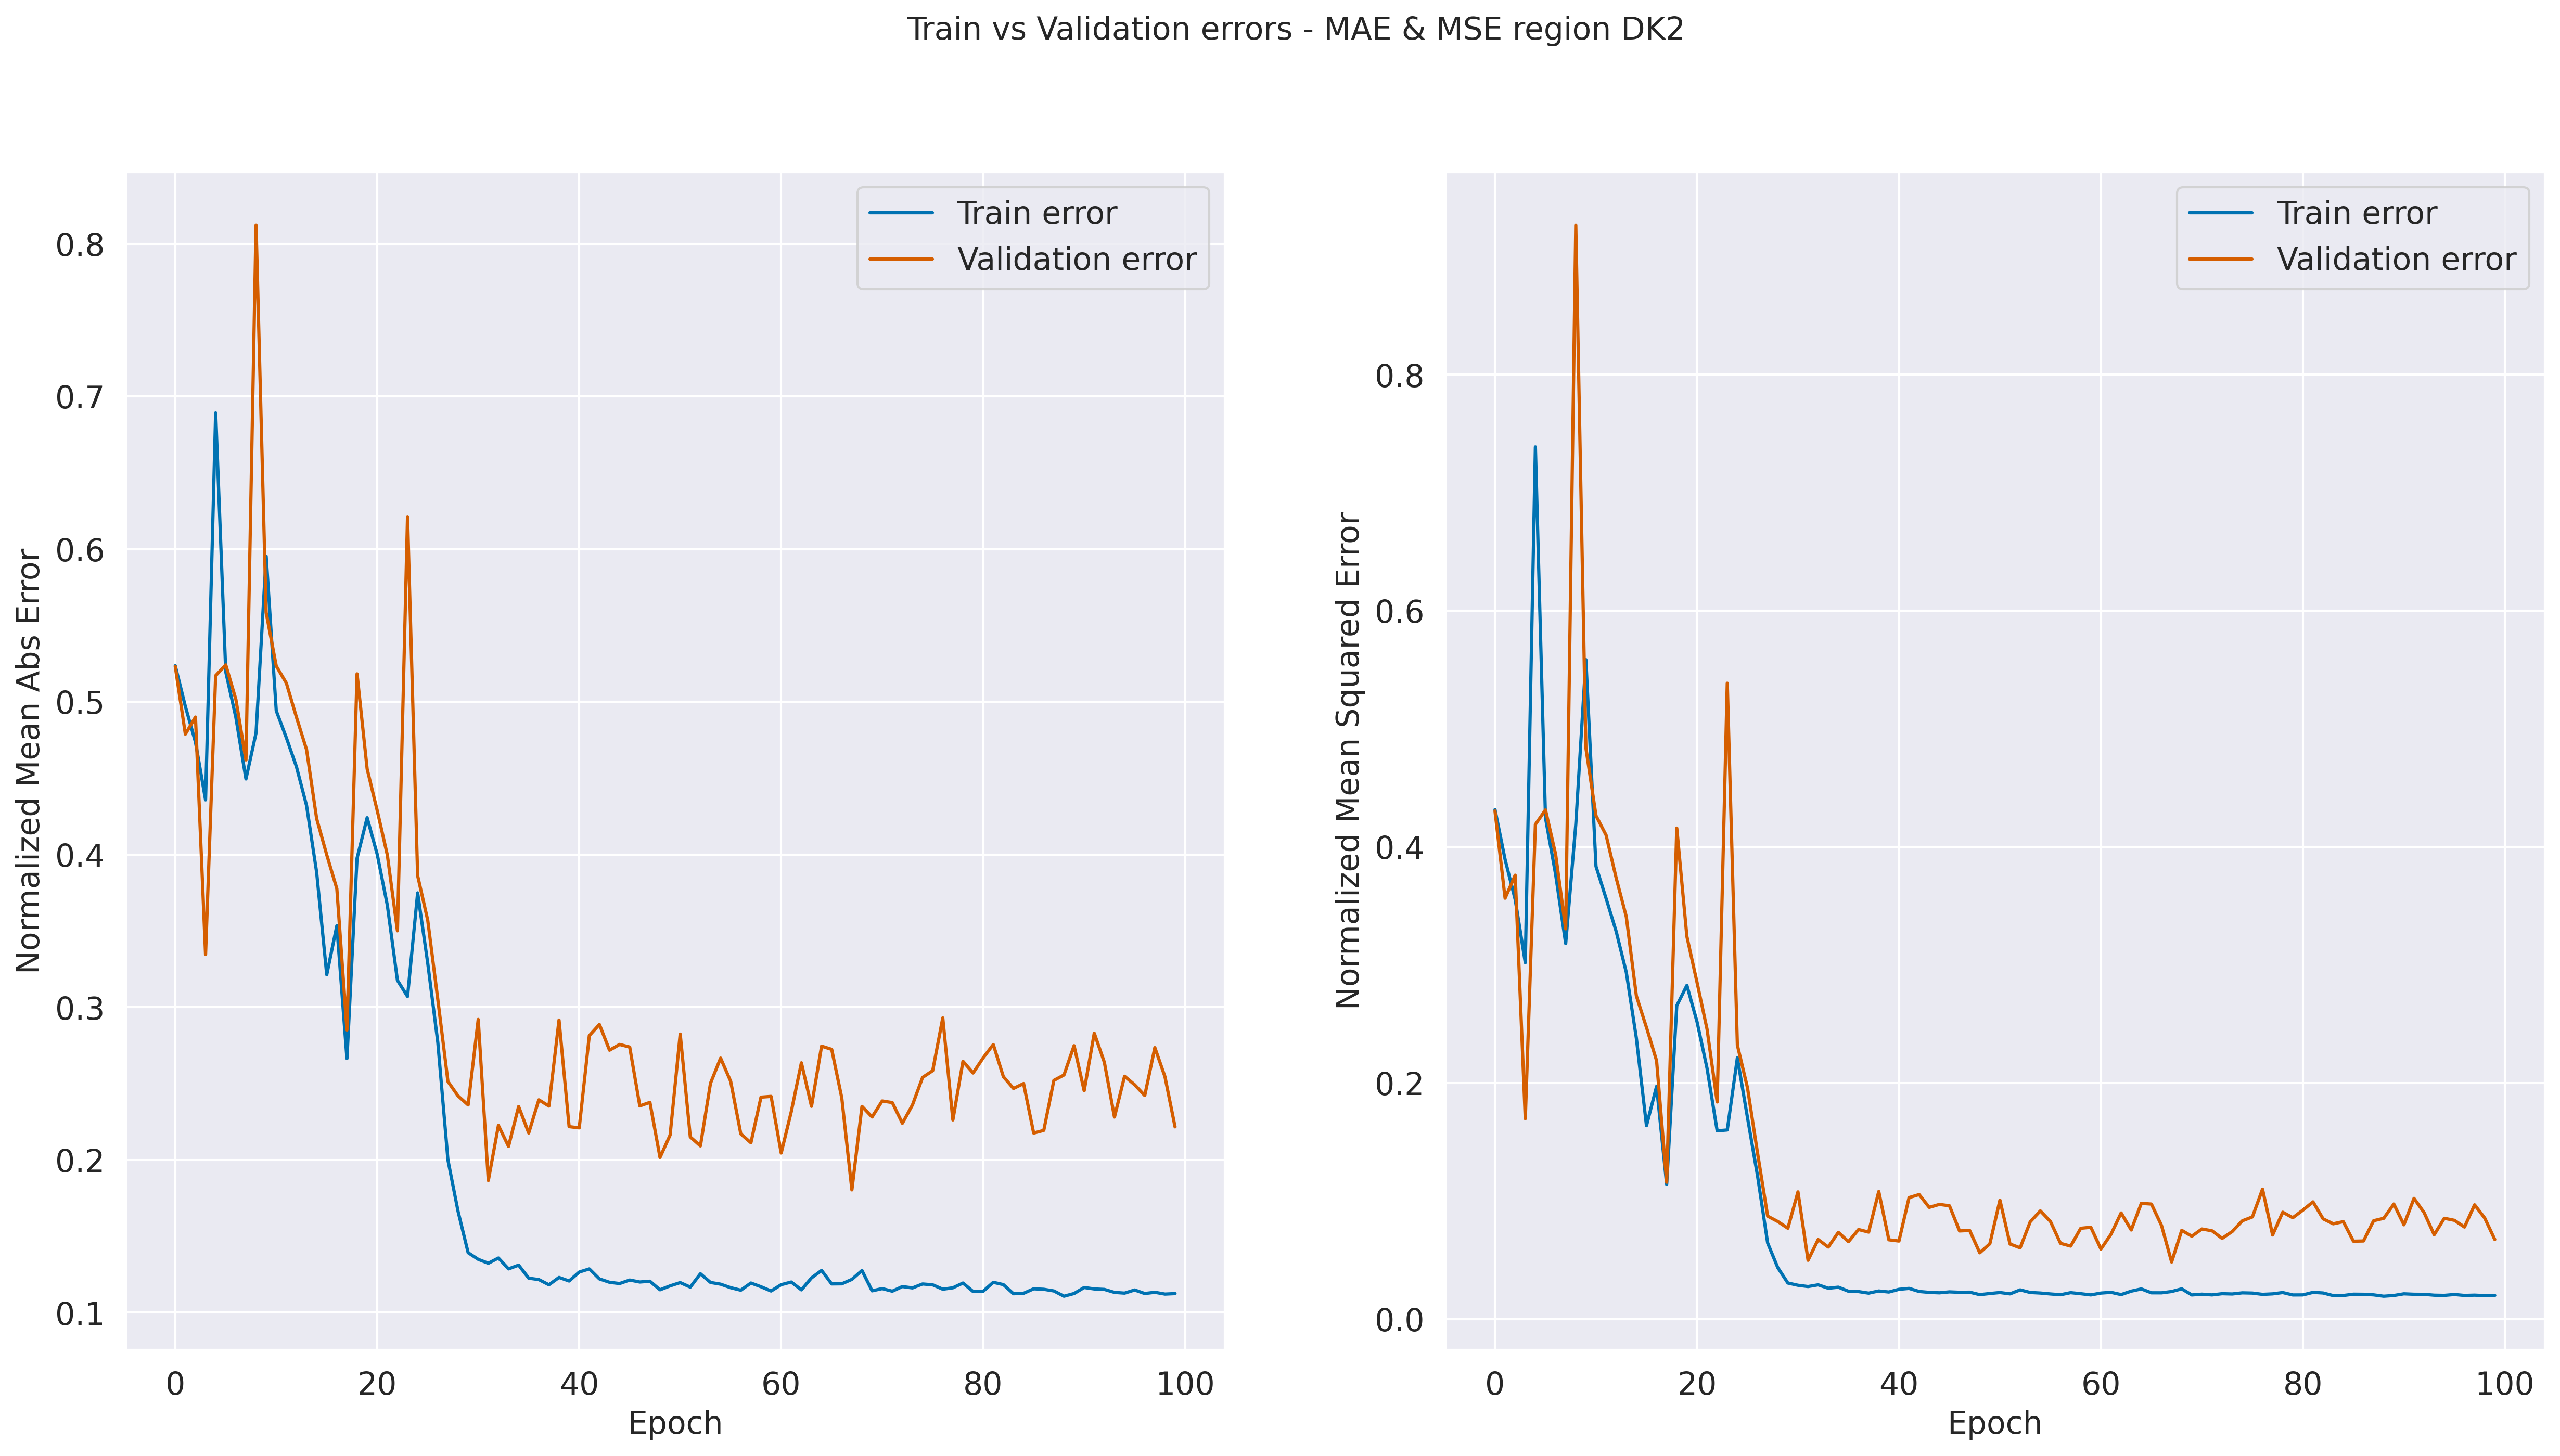

In [ ]:
def plot_history(history: tf.keras.callbacks.History, region) -> None:
  """
  Plot training vs Validation MAE and MSE over epoch
  """
  hist=pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  fig, axes = plt.subplots(nrows=1, ncols=2)
  fig.suptitle(f'Train vs Validation errors - MAE & MSE region {region}')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Normalized Mean Abs Error');
  axes[0].plot(hist['epoch'], hist['mae'], label='Train error')
  axes[0].plot(hist['epoch'], hist['val_mae'], 'C2', label='Validation error')
  axes[0].legend()
  
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Normalized Mean Squared Error');
  axes[1].plot(hist['epoch'], hist['mse'], label='Train error')
  axes[1].plot(hist['epoch'], hist['val_mse'], 'C2', label='Validation error')
  axes[1].legend()

  
  plt.legend()
  plt.savefig(f'drive/My Drive/MONTA/Plots/DistLambda_regions/Train_Val_errors_region_{region}.jpg')
  plt.show()
  print("\n")

plot_history(history, region)

In [ ]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 168, 200)          161600    
                                                                 
 flatten_15 (Flatten)        (None, 33600)             0         
                                                                 
 dense_15 (Dense)            (None, 97)                3259297   
                                                                 
 distribution_lambda_15 (Dis  ((None, 96),             0         
 tributionLambda)             (None, 96))                        
                                                                 
Total params: 3,420,897
Trainable params: 3,420,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
preds

[]

# Evaluation

### Extraction of predictions

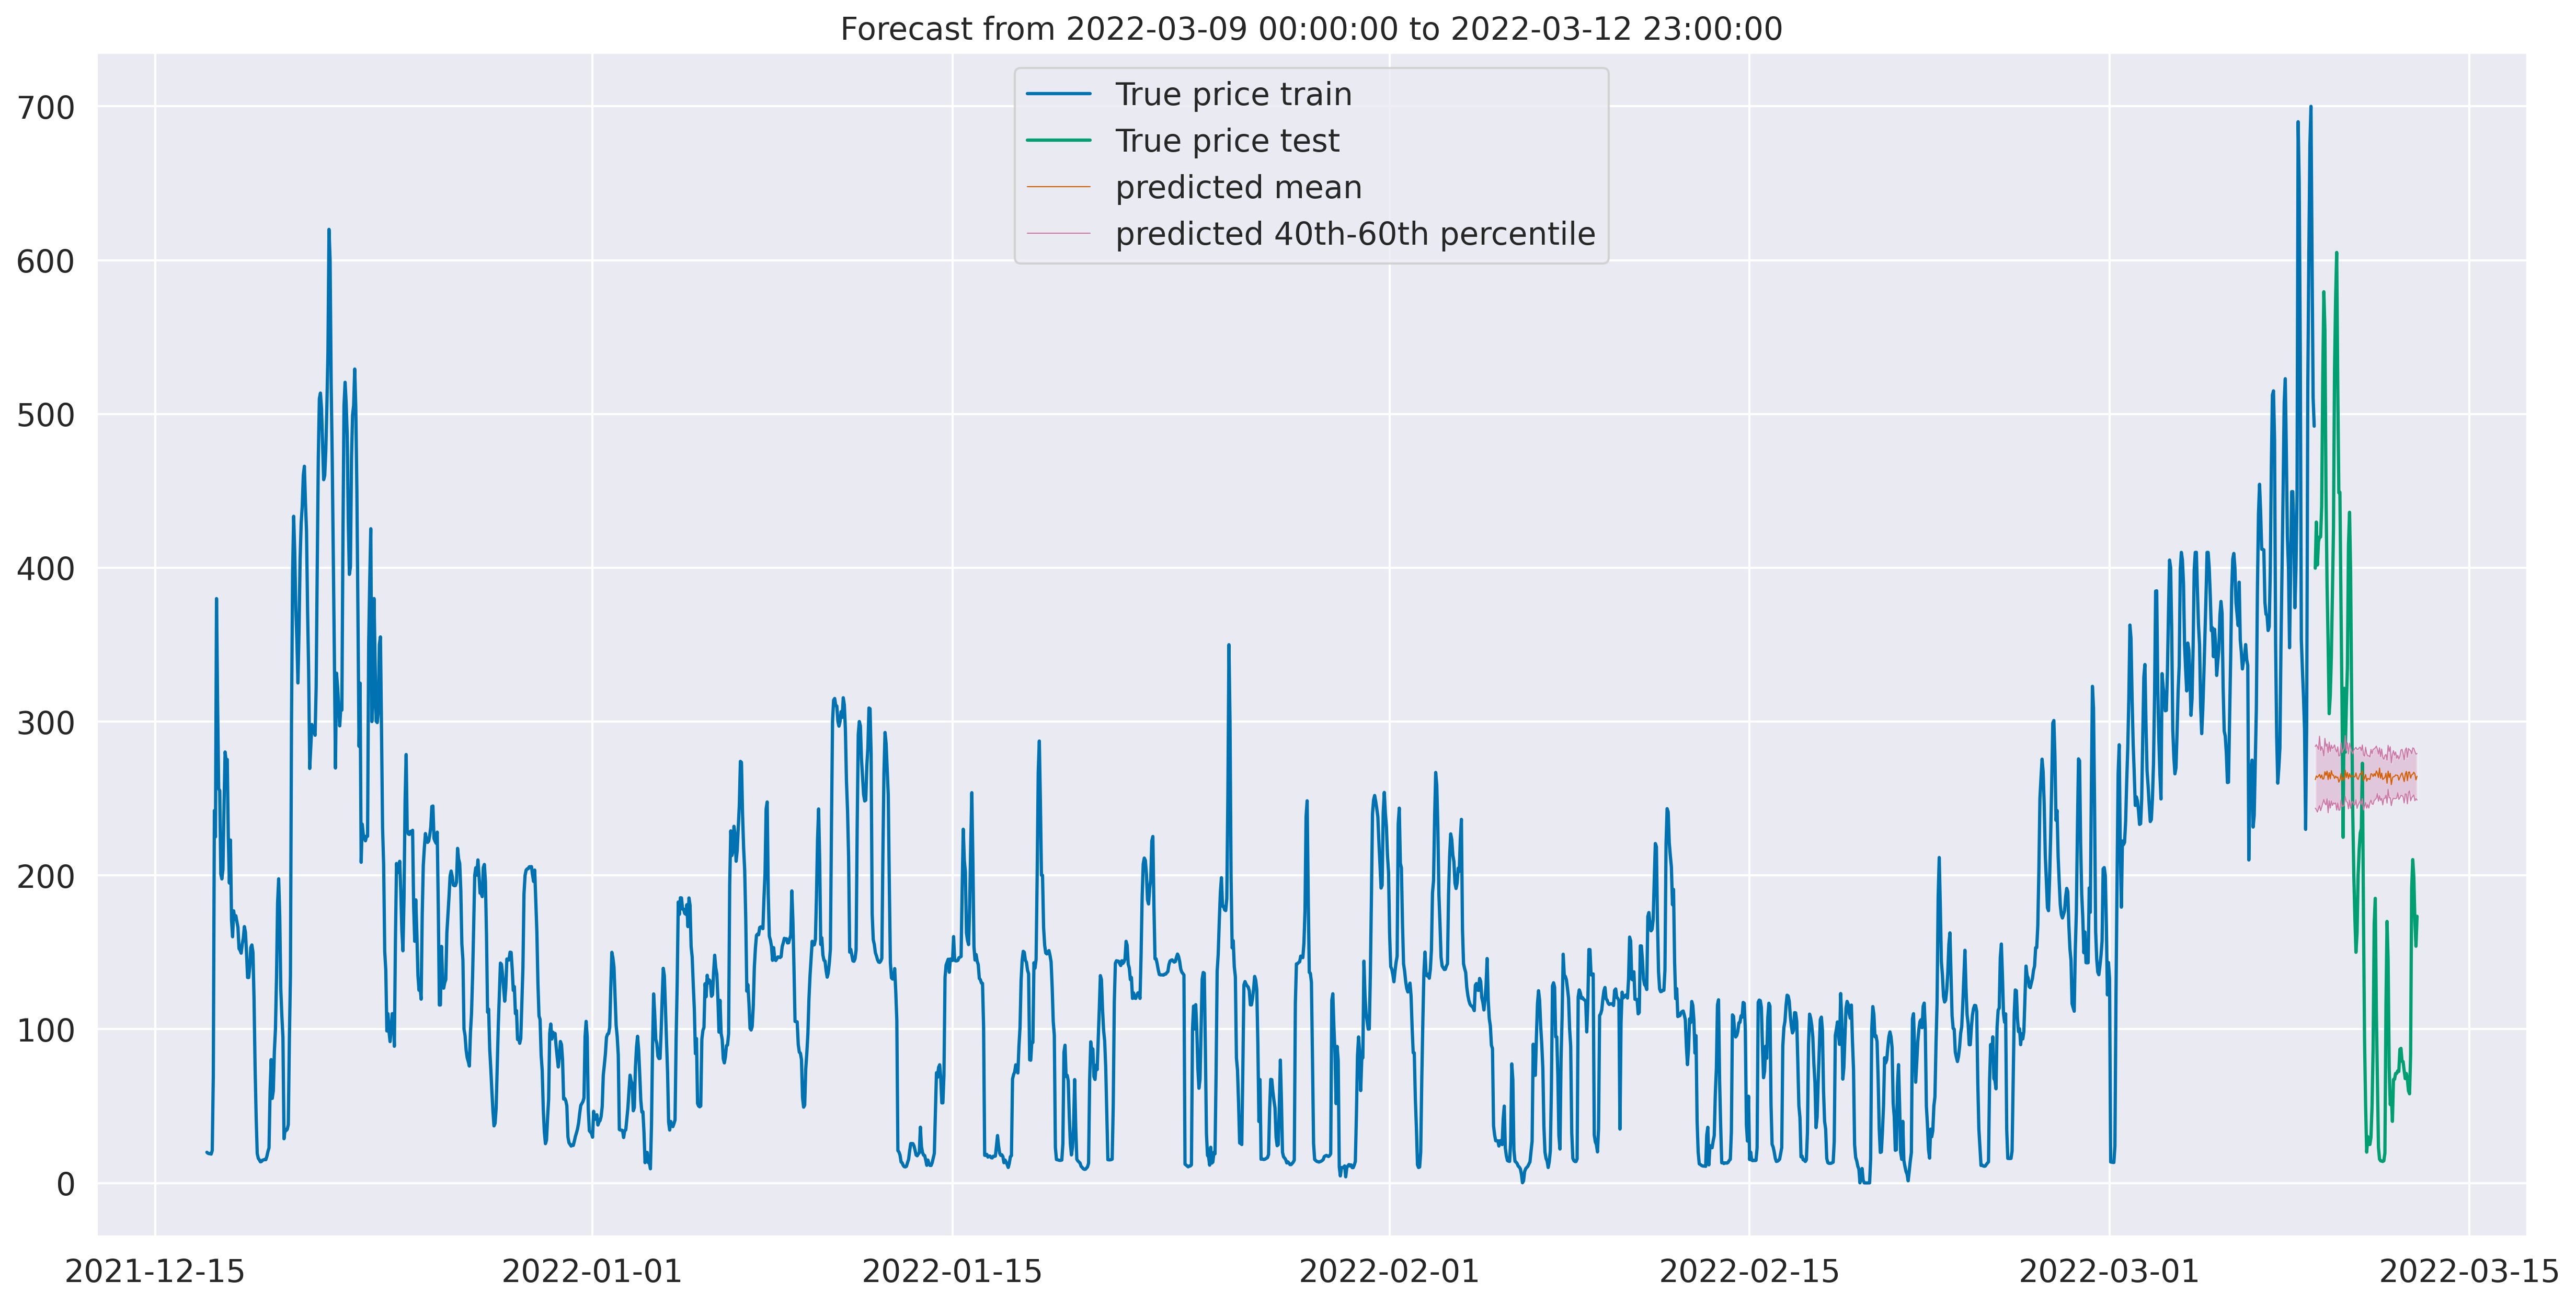

In [ ]:
plt.rcParams.update(params)

df_distr=pd.DataFrame()
# period_preds={}


##### Sampling and getting attributes (seed set in imports)
tensor_draw = yhat.sample(1000) # Sample a 1000 values since we want a better number to get better results (Law of large numbers)
df_samples_scaled=pd.DataFrame(tensor_draw.numpy().squeeze())
m=df_samples_scaled.mean(axis=0)
s=df_samples_scaled.std(axis=0)
q40=df_samples_scaled.quantile(q=.40,axis=0)
q60=df_samples_scaled.quantile(q=.60,axis=0)
distrib = {'mean':m, 'stddev':s, 'percentile_40':q40, 'percentile_60':q60} # Don´t get more percentiles, for more use Z-score
df_distr_scaled=pd.DataFrame(distrib)
##### De-normalization
denormed = lambda x: (x *(p_max - p_min) + p_min) 
df_distr=df_distr_scaled.copy()
for col in df_distr_scaled.columns:
  df_distr[col] = df_distr[col].apply(denormed)
# print(df_distr.tail()) ### Check transformations

##### Plotting


fig=plt.figure(figsize=[20, 10])
plt.plot(data, label = "True price train")
plt.plot(test, label = "True price test")
plt.plot(test.index, df_distr['mean'], linewidth=.5, label='predicted mean')
plt.plot(test.index, df_distr['percentile_40'], 'C3', linewidth=.5, label='predicted 40th-60th percentile')
plt.plot(test.index, df_distr['percentile_60'], 'C3', linewidth=.5)
plt.fill_between(test.index, df_distr['percentile_40'], df_distr['percentile_60'], facecolor='C3', alpha=.3)
plt.title(f'Probabilistic LSTM Forecast of region {region}')
plt.legend()
fig.savefig(f'drive/My Drive/MONTA/Plots/DistLambda_regions/Pred distlambda_lstm region {region}.jpg')
plt.show()
# # if ii== 3: break   #### Used for debugging

### RMSE

In [ ]:
rmse = (np.sqrt(mean_squared_error(test, df_distr['mean'])))
mape = calculate_mape(test, df_distr['mean'])
print(f' Average MAPE: {mape}')
print(f' Average RMSE: {rmse}')

 Average MAPE: 266.97
 Average RMSE: 174.6361735324281


### Time-related

In [ ]:
preds_values = df_distr['mean'].values

preds_idx = pd.to_datetime(test.index)
#preds_idx

In [ ]:
preds_values

array([262.29629116, 264.58844749, 263.73837267, 264.56149542,
       265.62205502, 263.3227226 , 265.30023651, 262.57576238,
       262.85525446, 267.32917213, 265.05362094, 267.77784474,
       262.32128231, 266.78942156, 262.80708703, 268.1086125 ,
       265.11405448, 265.19286632, 263.0690561 , 264.47780217,
       263.5121589 , 263.88423091, 260.58696281, 262.13910555,
       266.19182418, 261.74026922, 263.57751557, 262.04955042,
       268.38407846, 263.65382413, 266.89969138, 262.82959576,
       266.08647748, 263.82427717, 264.89864656, 264.58248132,
       264.13259878, 264.04003971, 266.60346899, 263.32608117,
       262.34925656, 264.45176797, 266.21835903, 265.71505216,
       268.0134667 , 261.60498737, 263.15715097, 265.58511066,
       261.23362463, 263.04694372, 262.72687752, 262.38000527,
       266.06038071, 265.80562945, 264.27088457, 266.07663122,
       264.5860485 , 267.92084506, 266.28997392, 263.62532837,
       269.72100103, 263.16766478, 266.45900843, 262.35

In [ ]:
preds_df = pd.DataFrame(data=preds_values, index = preds_idx)
preds_df.reset_index(inplace = True)
preds_df.columns = ["datetime", "Predicted Price"]
preds_df["hour"] = preds_df["datetime"].dt.hour
preds_df["dayofweek"] = preds_df["datetime"].dt.weekday
#true_test = data.reset_index()
preds_df = preds_df.merge(test, how = "left", on = "datetime")
# Square root of the incremental mean of the difference
preds_df["RMSE"] = np.sqrt(((preds_df["Predicted Price"] - preds_df[f'{region}'])**2).expanding().mean()) 

In [ ]:
drive_path='drive/My Drive/MONTA/'
folder = "Plots/"
subfolder = "DistLambda_regions/"
filename = f"/Preds_{region}"
filetype = ".csv"
preds_df.to_csv(path_or_buf=drive_path+folder+subfolder+filename+filetype)
preds_df.head() # Data check

,datetime,Predicted Price,hour,dayofweek,DK2,RMSE
0,2022-03-09 00:00:00,262.296291,0,2,399.73,137.433709
1,2022-03-09 01:00:00,264.588447,1,2,429.70,151.904327
2,2022-03-09 02:00:00,263.738373,2,2,401.80,147.434575
3,2022-03-09 03:00:00,264.561495,3,2,416.88,148.670600
4,2022-03-09 04:00:00,265.622055,4,2,420.03,149.835645


hour
0     166.784115
1     170.045743
2     168.610261
3     168.660050
4     168.621895
5     168.515460
6     168.879680
7     172.695548
8     177.761833
9     180.326666
10    179.500973
11    177.949186
12    176.426657
13    174.826703
14    173.576671
15    172.528119
16    171.838079
17    171.558237
18    172.405489
19    173.756520
20    175.510335
21    175.857811
22    175.846853
23    176.035750
Name: RMSE, dtype: float64

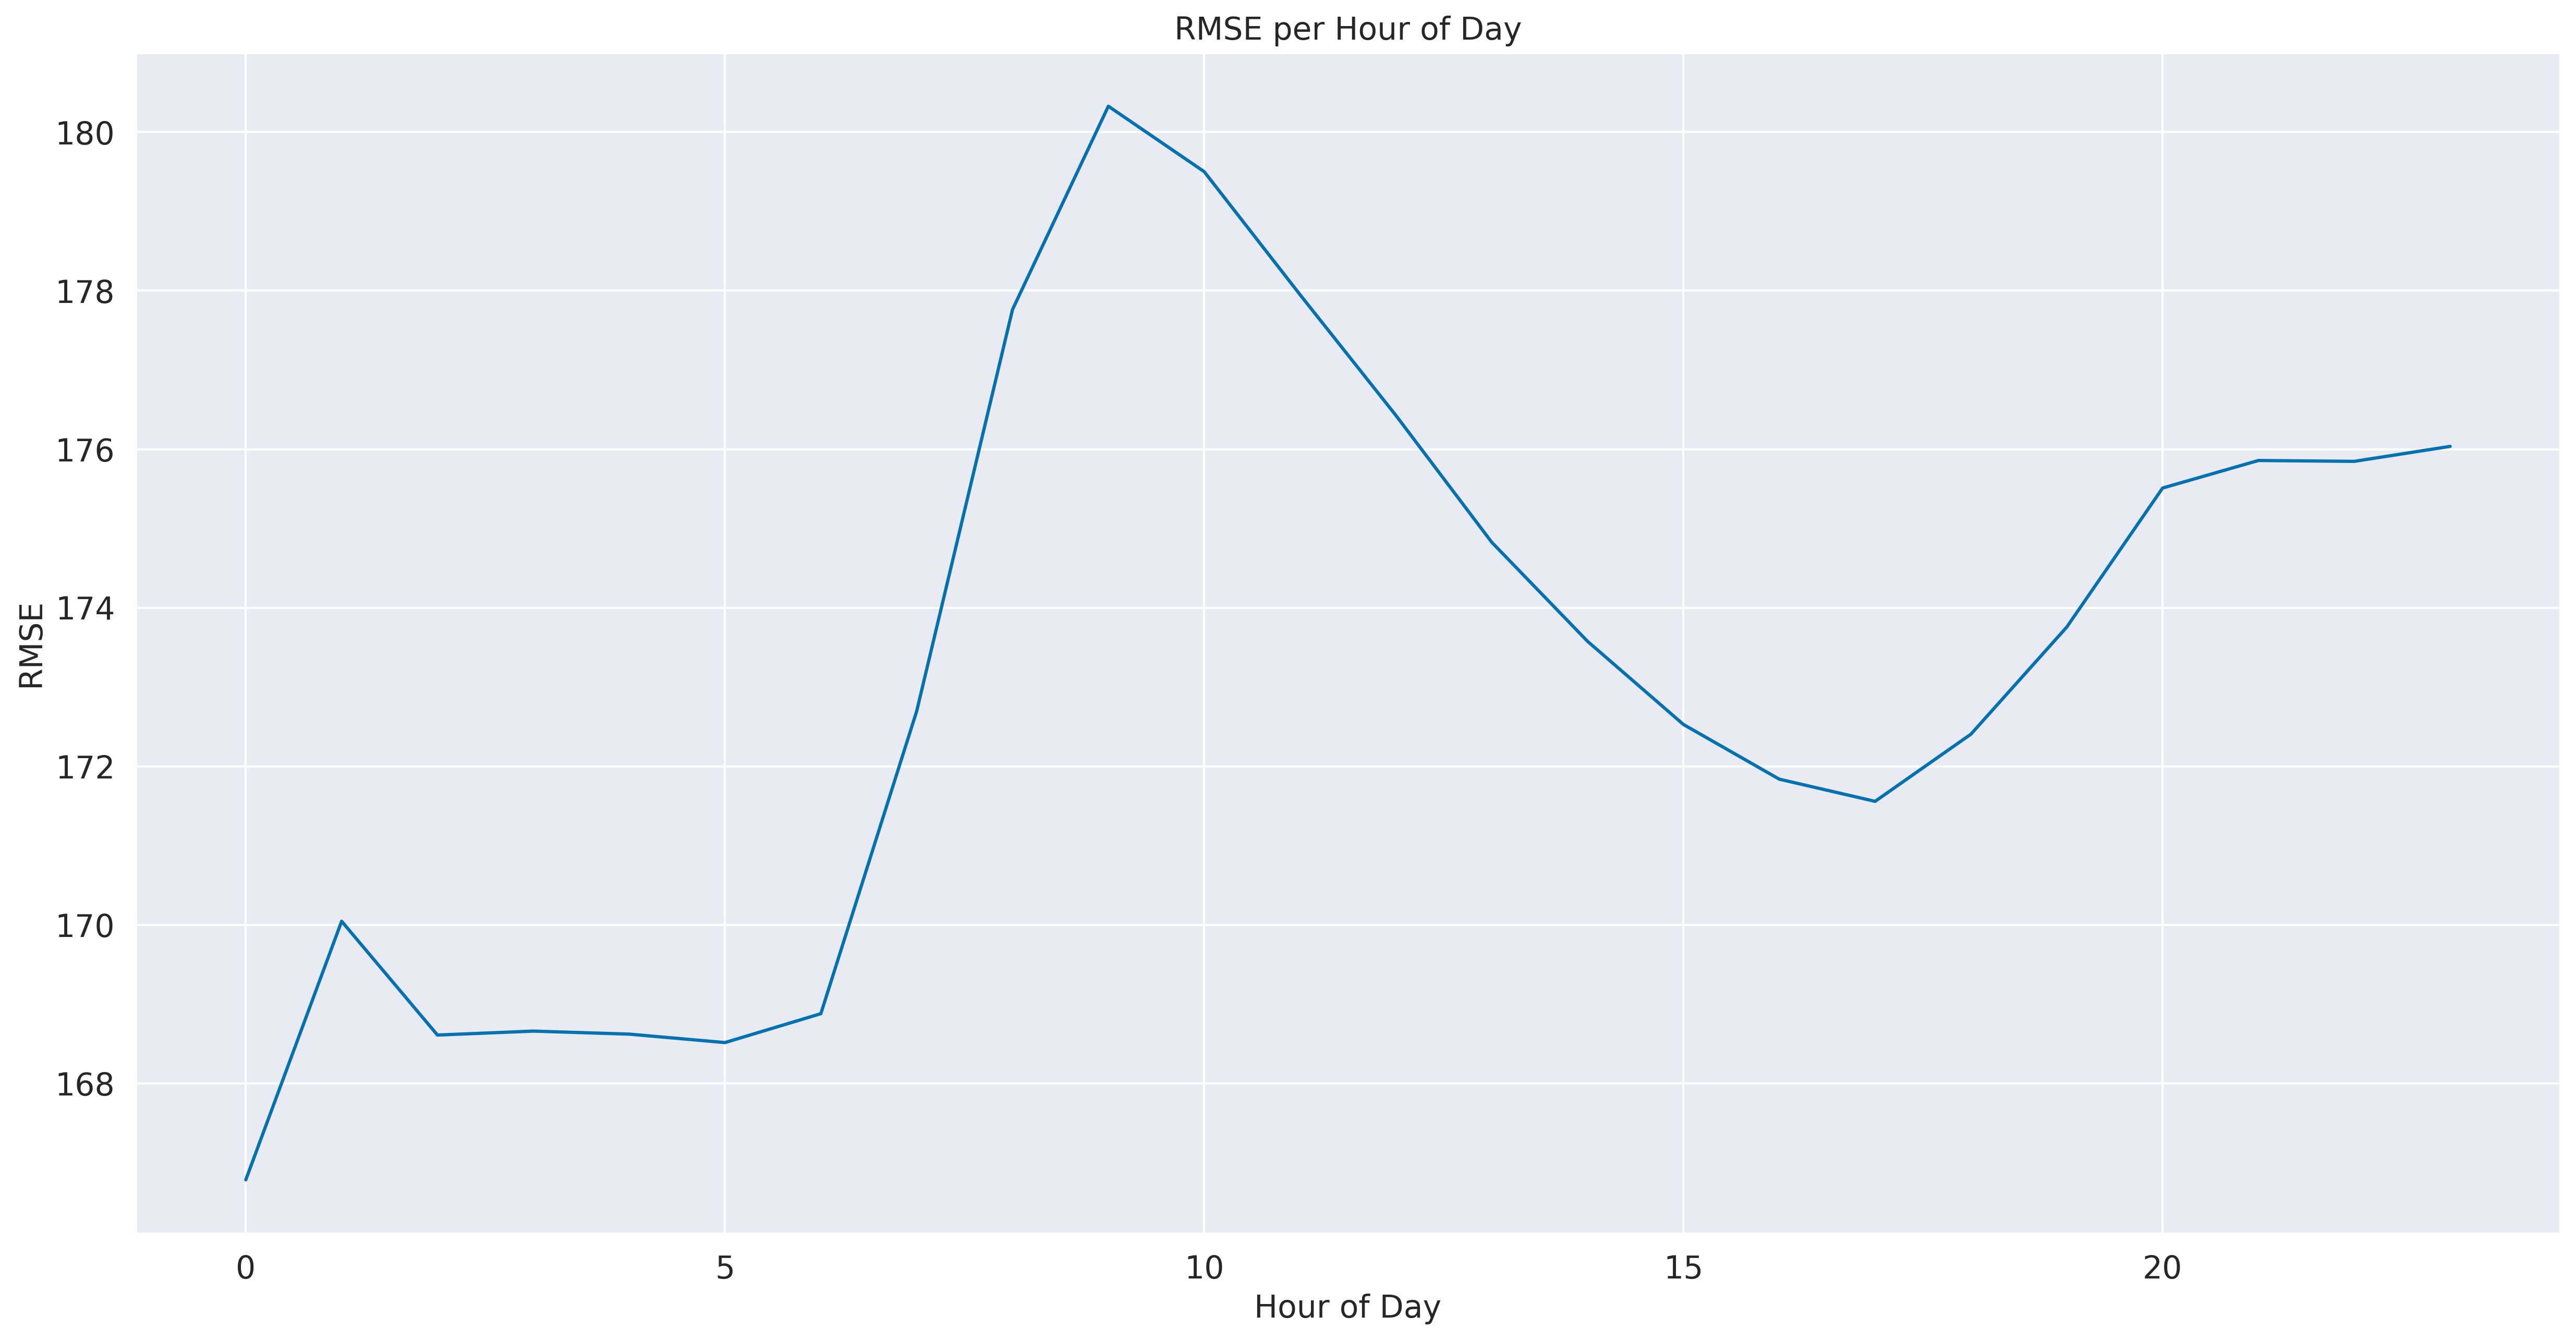

In [ ]:
hour_preds = preds_df.groupby("hour")["RMSE"].mean()
display(hour_preds)
plt.plot(hour_preds,"C0")
plt.xlabel('Hour of Day') 
plt.ylabel('RMSE') 
plt.title("RMSE per Hour of Day")
plt.savefig(f'drive/My Drive/MONTA/Plots/DistLambda_regions/Region {region} Hourly error.jpg')
plt.show()

dayofweek
2    176.505760
3    170.576718
4    168.799649
5    177.204312
Name: RMSE, dtype: float64

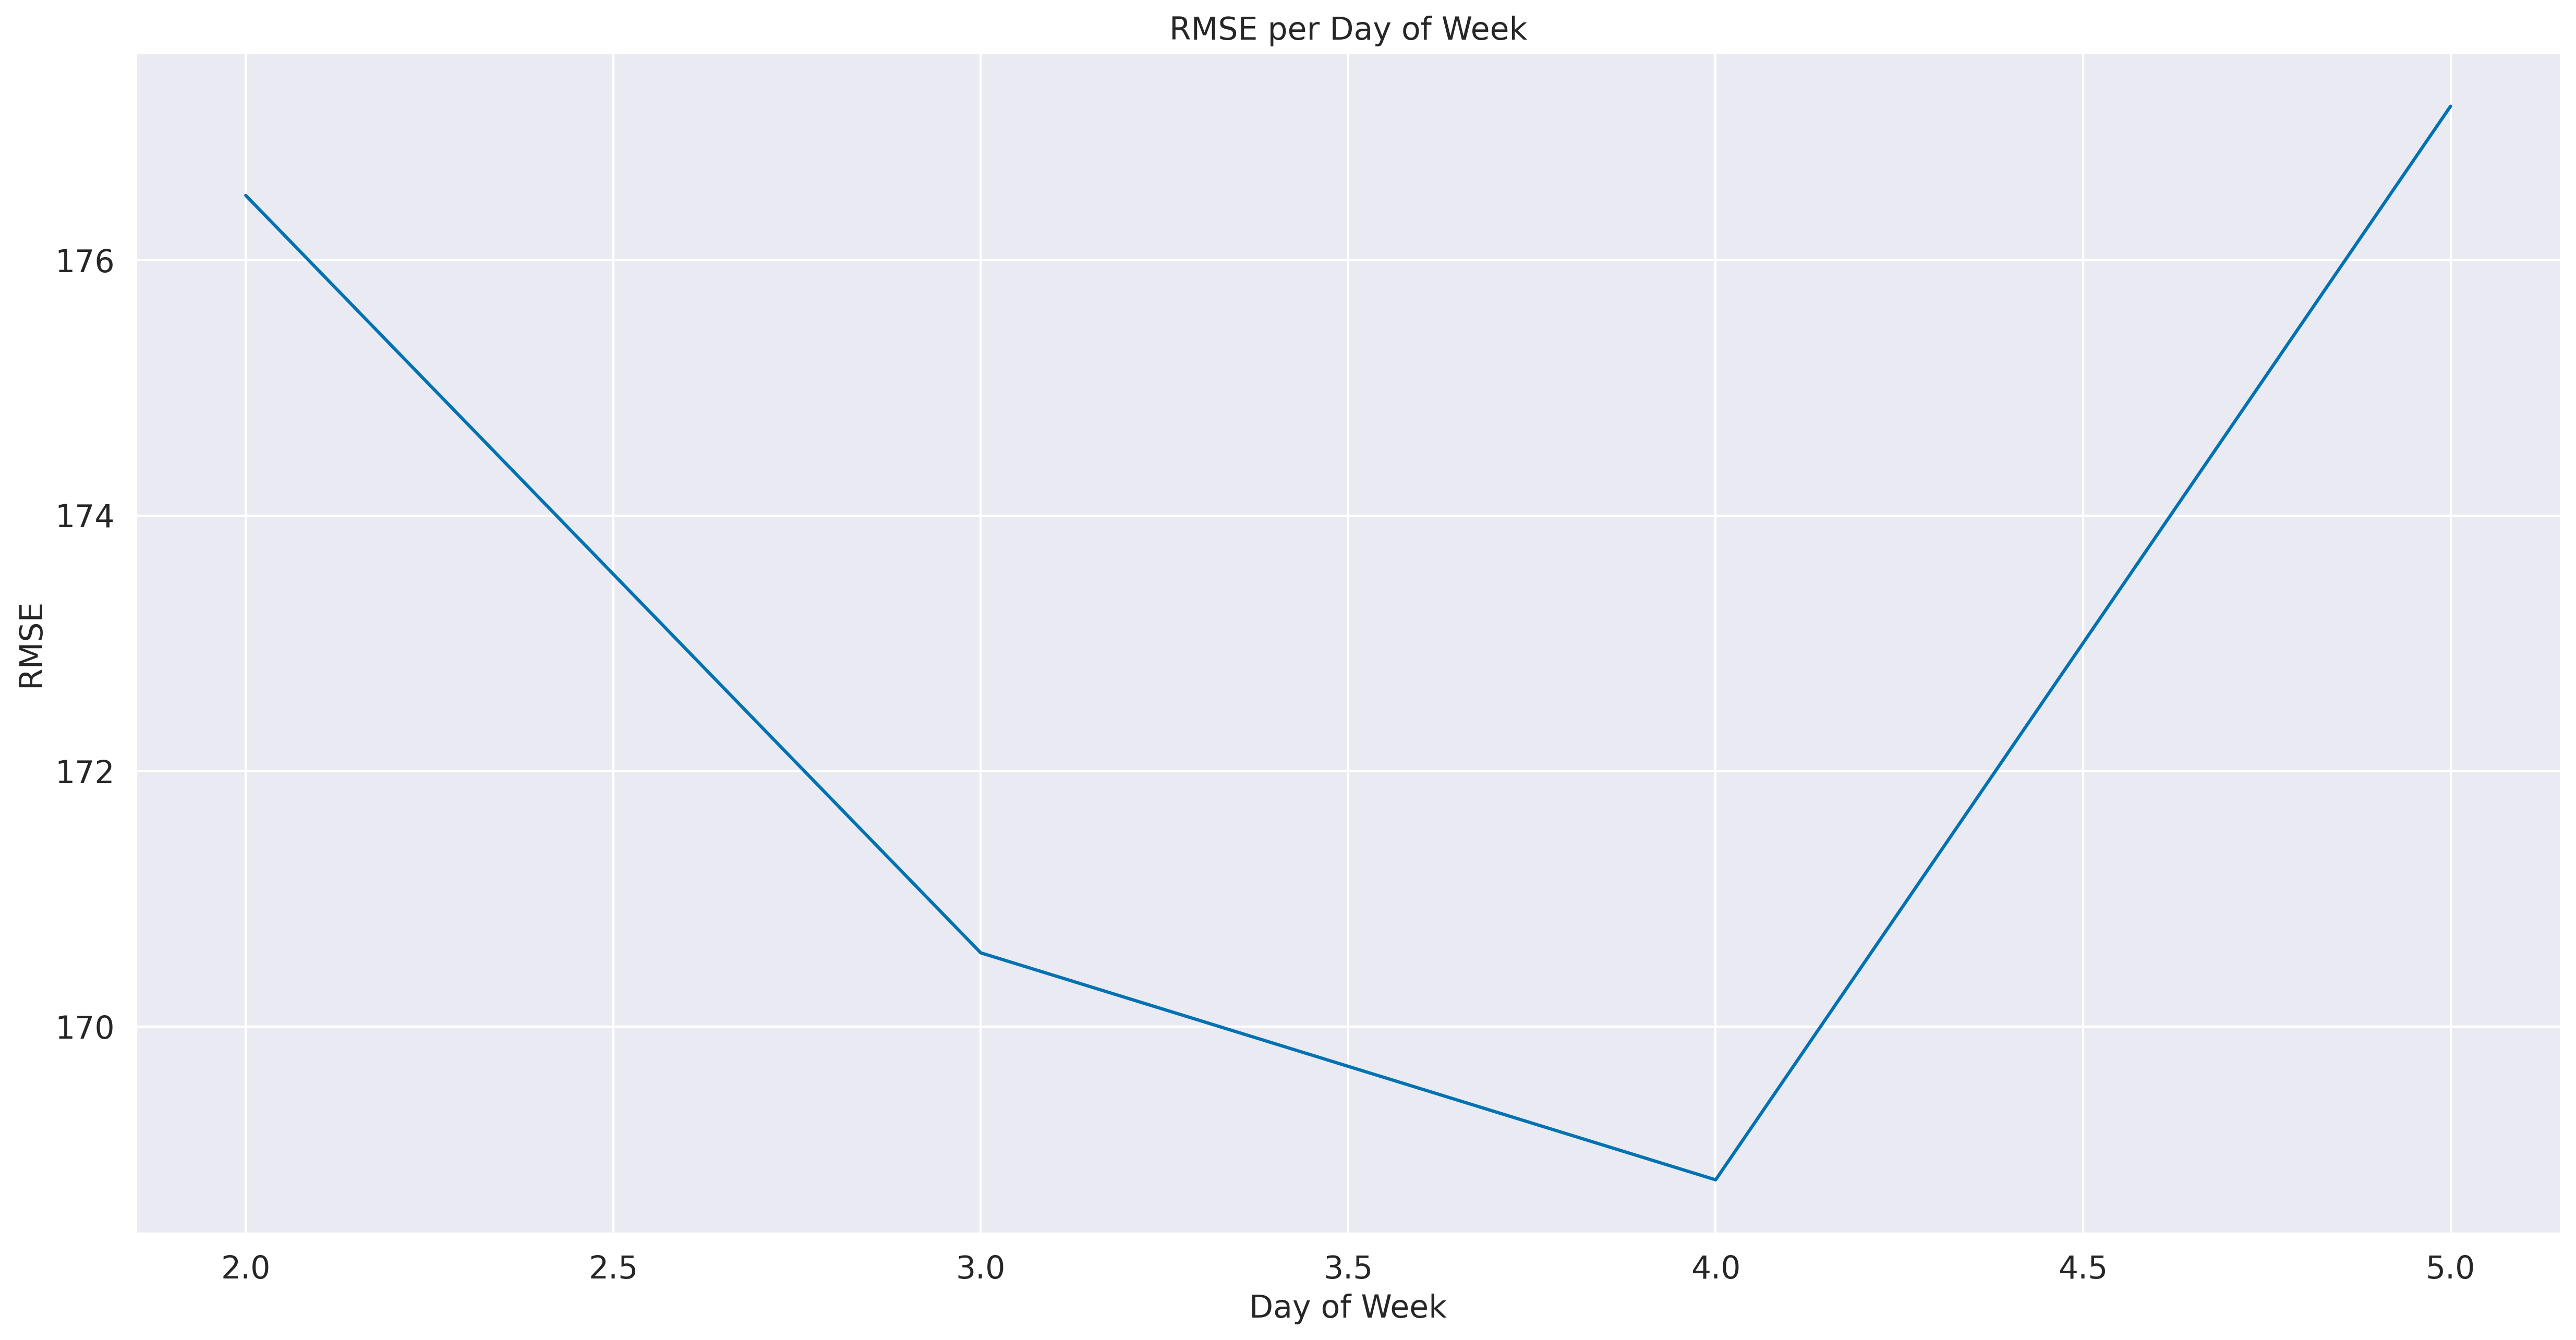

In [ ]:
preds_df["dayofweek"] = preds_df["datetime"].dt.dayofweek
weekday_preds = preds_df.groupby("dayofweek")["RMSE"].mean()
display(weekday_preds)
plt.plot(weekday_preds,"C0")
plt.xlabel('Day of Week') 
plt.ylabel('RMSE') 
plt.title("RMSE per Day of Week")
plt.savefig(f'drive/My Drive/MONTA/Plots/DistLambda_regions/Region {region} Day of Week error.jpg')
plt.show()

dayofweek,2,3,4,5
hour,,,,
0,137.433709,195.490241,158.343239,175.869274
1,151.904327,191.933980,160.174165,176.170500
2,147.434575,188.494282,162.049341,176.462845
3,148.670600,185.439517,163.823880,176.706204
4,149.835645,182.227157,165.485426,176.939352
5,151.002634,179.364603,166.553580,177.141021
6,154.610469,176.871453,166.734352,177.302444
7,171.591079,176.142814,165.753356,177.294942
8,193.155153,175.959044,164.630271,177.302864


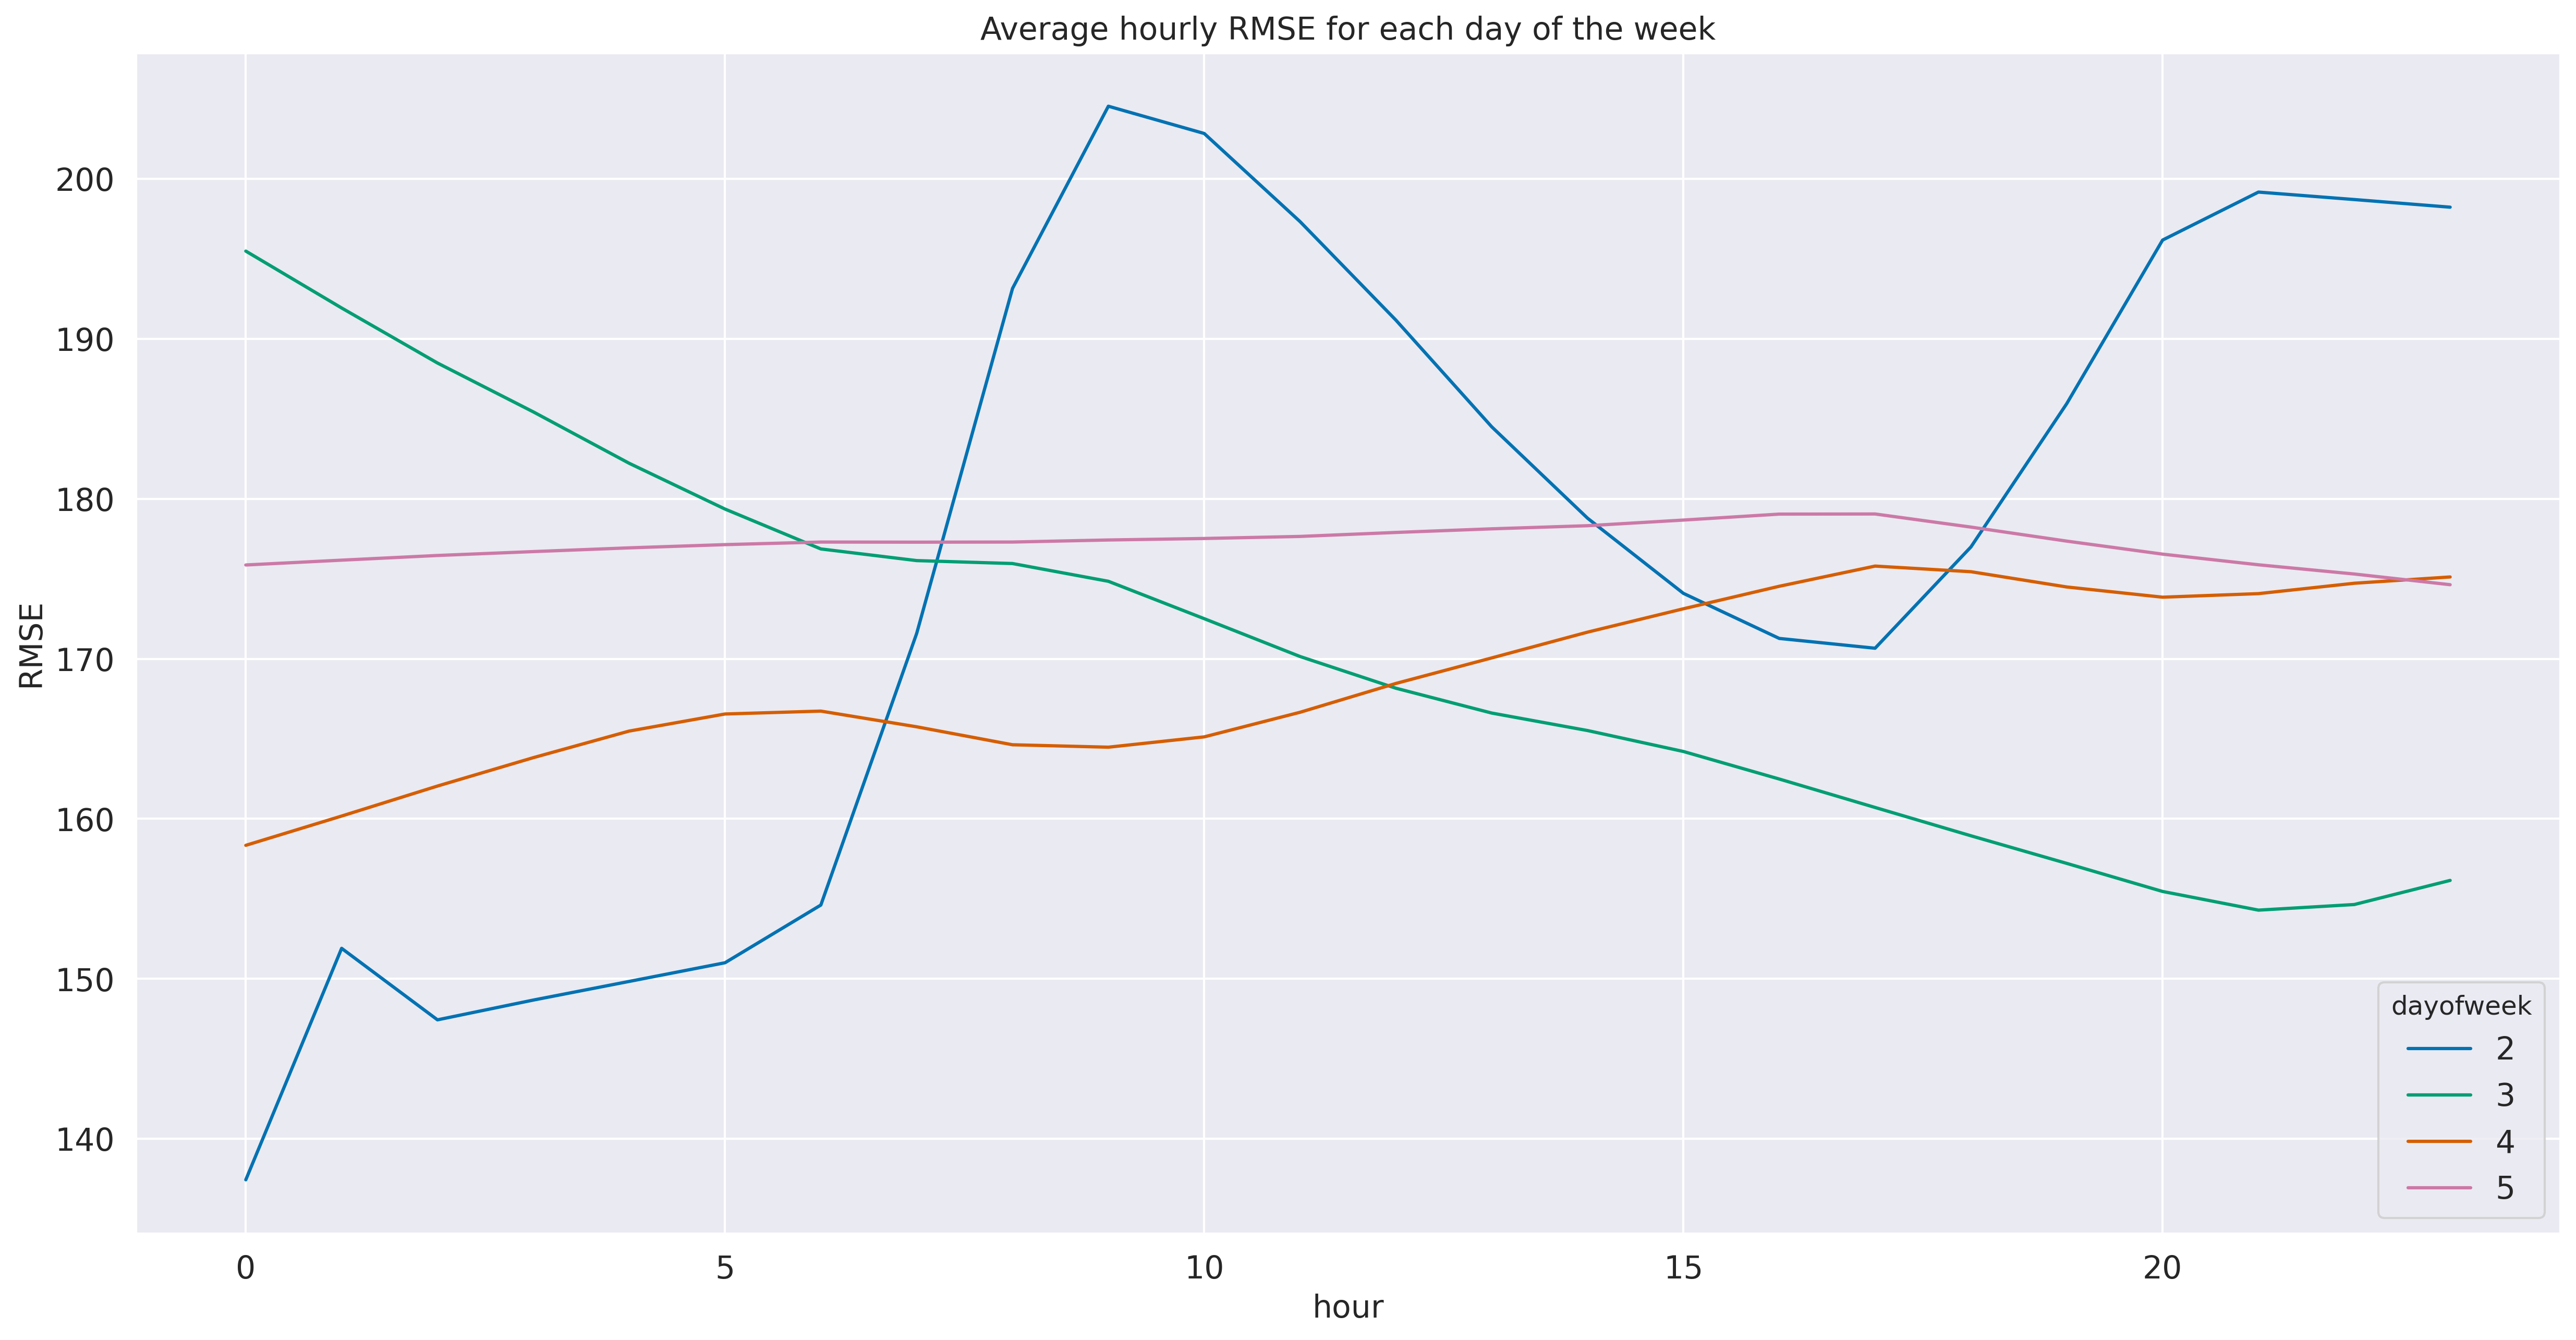

In [ ]:
hour_day = pd.pivot_table(data = preds_df, values="RMSE",
                            index = "hour", columns="dayofweek",
                            aggfunc="mean")
display(hour_day)
hour_day.plot()
plt.ylabel("RMSE")
plt.title("Average hourly RMSE for each day of the week")
plt.savefig(f'drive/My Drive/MONTA/Plots/DistLambda_regions/Region {region} Average hourly RMSE for each day.jpg')
plt.show()